In [4]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [5]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras import utils # utils.to_categorical() : 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# 로지스틱 회귀분석(이진분류)
## 1. 데이터 셋 생성 & 전처리

In [8]:
# 1. csv파일을 데이터프레임을 읽어오기(결측치처리, 균형확인 용이) 기본encoding=utf-8
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
df.head()
# 0. 임신횟수
# 1. 2시간내 포도당 농도
# 2. 혈압
# 3. 피부접힘 두께
# 4. 인슐린수치
# 5. BMI체질량지수
# 6. 가족력
# 7. 나이

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
df.shape

(768, 9)

In [10]:
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
df.isna().sum() # 열별 결측치 갯수

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [12]:
# 타겟변수의 균형
df[8].value_counts()/len(df)

0    0.651042
1    0.348958
Name: 8, dtype: float64

In [13]:
df.values
df.to_numpy()

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [14]:
# 2. csv파일을 numpy 배열로 읽어오기 : np.loadtxt() #이 있는 행은 제외하고 읽어오기
        #기본 encoding=cp949
dataset = np.loadtxt('data/pima-indians-diabetes.csv',delimiter=',', encoding='utf-8') # delimiter : 구분자, 
dataset.shape

(768, 9)

In [15]:
# 데이터 분할 : 학습데이터셋(모델학습용) + 시험데이터셋(모델평가용)
X_train = dataset[:620, :-1]
y_train = dataset[:620, -1]
X_test  = dataset[620:, :-1]
y_test  = dataset[620:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((620, 8), (620,), (148, 8), (148,))

## 2. 모델구성

In [16]:
model = Sequential()
# model.add(Dense(units=32, input_dim=8, #input_shape=(8,)
#                activation='relu'))
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='elu'))
model.add(Dense(units=1, activation='sigmoid')) # 이진분류 출력층 활성화함수 : sigmoid
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [17]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 코드가 더 간단하고 범용적이어서 다른 분류 문제에도 재사용 가능
# Keras 최신 버전에서는 accuracy만 써도 자동으로 이진/다중 분류 구분
# 기능적으로는 두 코드가 동일 → 단순히 명칭 차이

## 4. 학습

In [18]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터셋(학습데이터셋)
                epochs=200,
                batch_size=310,
                # validation_data=(X_test, y_test), 검증데이터셋
                validation_split=0.1, # 검증데이터비율(훈련데이터에서 10%를 검증용데이터로)
                verbose=0) # log 출력 X

CPU times: total: 6.38 s
Wall time: 6.08 s


In [19]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 5. 모델 평가하기
- 학습과정 시각화하여 살펴보기
- 평가
- 교차표(혼동매트릭스, 성능평가지표) 그리기

In [21]:
hist.history.keys()
# 🔹 val_loss / val_accuracy
# ➡ 훈련(training) 데이터에 대해 계산된 값
# loss: 모델이 훈련 데이터에서 얼마나 틀리는지
# accuracy: 모델이 훈련 데이터에서 맞춘 비율
# 즉, 모델이 학습에 사용한 데이터에 대해 얼마나 잘 맞추는지를 보여주는 지표.

# 🔹 val_loss / val_accuracy
# ➡ 검증(validation) 데이터에 대해 계산된 값
# val_loss: 모델이 검증 데이터에서 얼마나 틀리는지
# val_accuracy: 모델이 검증 데이터에서 맞춘 비율
# 즉, 학습에 사용하지 않은 데이터(검증 데이터)에 대해 얼마나 일반화되는지를 보여주는 지표.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

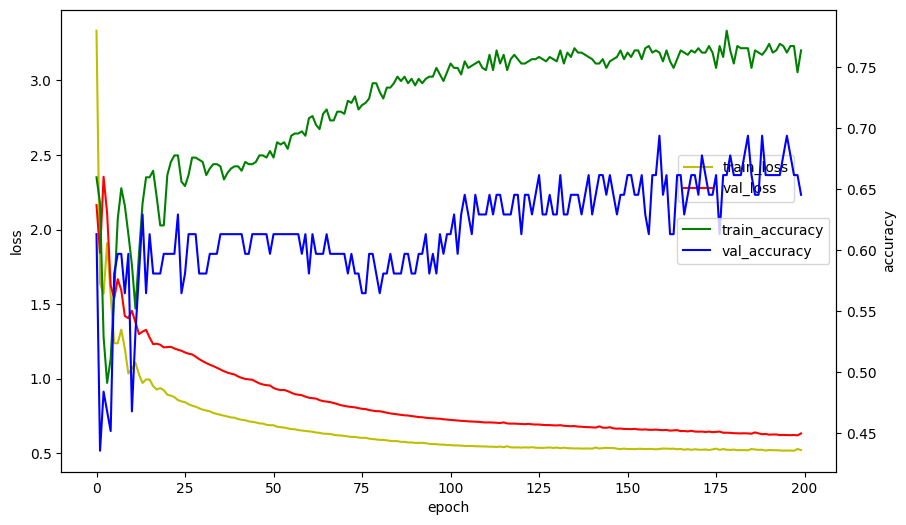

In [22]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
# (0.955, 0.7) 의미
# 0.955 → x축 기준 오른쪽 끝 근처
# 0.7 → y축 기준 위쪽 70% 지점
# 즉, 범례 상자를 그래프 오른쪽 위쪽 근처, 높이는 70% 지점에 놓겠다는 뜻
acc_ax.legend(loc='center right')
plt.show()

In [23]:
# 모델 평가(X)
# model.evaluate(X_train, y_train)

20/20 [==============================] - 0s 1ms/step - loss: 0.5374 - accuracy: 0.7435


[0.537443995475769, 0.7435483932495117]

In [24]:
# ★ 모델 평가(O)★
score = model.evaluate(X_test, y_test)
print("loss : {}, 정확도 : {:.2f}%".format(score[0], score[1]*100))

5/5 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6824
loss : 0.6325758695602417, 정확도 : 68.24%


In [25]:
# 교차표(혼동매트릭스, 성능평가지표) 그리기 : 테스트셋의 실제값과 예측값
y_hat = (model.predict(X_test) > 0.5).astype(int)
y_test.shape, y_hat.shape # 실제값(1차원), 예측값(2차원)

5/5 [==============================] - 0s 2ms/step


((148,), (148, 1))

In [26]:
y_hat.reshape(-1).shape #혼동행렬(Confusion Matrix) 같은 함수는 1차원 벡터 형태를 요구

(148,)

In [27]:
TN=0; FP=0; FN=0; TP=0;
for y, h in zip(y_test, y_hat.reshape(-1)):
    # print(y, h)
    if y==0 and h==0:
        TN += 1  # TN갯수 하나 증가
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

87 9
38 14


In [28]:
ctab = pd.crosstab(y_test, y_hat.reshape(-1)) # y_hat에러남
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

pd.crosstab(y_test, # 실제값
           y_hat.reshape(-1), # 예측값
           rownames=['실제값'], # index이름
           colnames=['예측값']) # column이름  : 결과가 데이터 프레임인 교차표

예측값,0,1
실제값,,
0.0,87,9
1.0,38,14


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat) # y_hat.reshape(-1) 둘다 가능
# 결과가 numpy배열인 혼동행렬

array([[87,  9],
       [38, 14]], dtype=int64)

## 6. 모델 사용(예측, 저장)

In [31]:
X_test

array([[  2.   , 112.   ,  86.   , ...,  38.4  ,   0.246,  28.   ],
       [  2.   ,  92.   ,  76.   , ...,  24.2  ,   1.698,  28.   ],
       [  6.   , 183.   ,  94.   , ...,  40.8  ,   1.461,  45.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [30]:
X_test[0]

array([  2.   , 112.   ,  86.   ,  42.   , 160.   ,  38.4  ,   0.246,
        28.   ])

In [33]:
(model.predict([[2, 112,  86,  42, 160,  38.4,   0.246, 28]])>0.5 ).astype(int)
# (model.predict([[2, 112,  86,  42, 160,  38.4,   0.246, 28]])>0.5 ).astype(bool) -> 결과는 False

1/1 [==============================] - 0s 49ms/step


array([[0]])

In [34]:
(model.predict([[2, 112,  86,  42, 160,  38.4,   0.246, 28],
                [1, 115,  86,  42, 160,  38.4,   0.246, 60],
               ])>0.5 ).astype(int)

1/1 [==============================] - 0s 52ms/step


array([[0],
       [0]])

In [35]:
from tensorflow.keras.models import save_model, load_model
model.save('model/06binary.h5')
save_model(model, 'model/06binary.h5')

In [36]:
model2 = load_model('model/06binary.h5')

In [37]:
(model2.predict([[2, 112,  86,  42, 160,  38.4,   0.246, 28]]) > 0.5 ).astype(int)

1/1 [==============================] - 0s 75ms/step


array([[0]])

# 분류분석
- 1. 데이터 생성 및 전처리 : 훈련셋600, 검증셋100, 테스트셋 68으로 분리, 타겟변수의 원핫인코딩
- 2. 모델생성(input 8, output 2) : 출력층의 활성화함수 : 'softmax'
- 3. 모델학습과정 loss='categorical_crossentropy', metrics=['accuracy']
- 4. 모델 학습 validation_data = [X_val, Y_val]
    * cf. validation_split = 0.1
- 5. 모델 학습 평가
- 6. 모델 사용 - 예측시 argmax()함수 활용
               0   1
              0.99 0.01
              
## 1. 데이터셋 생성및 전처리

In [38]:
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
dataset = df.values
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [39]:
# 훈련셋600, 검증셋100, 테스트셋68
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val   = dataset[600:700, :-1]
y_val   = dataset[600:700, -1]
X_test  = dataset[700:, :-1]
y_test  = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [43]:
# 분류분석을 위한 타겟(종속)변수의 원핫인코딩
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val)
Y_test  = utils.to_categorical(y_test)
Y_train.shape, Y_val.shape, Y_test.shape

((600, 2), (100, 2), (68, 2))

In [46]:
print('원본 데이터 :', y_train[:3])
print('원핫인코딩 데이터 :\n', Y_train[:3])

원본 데이터 : [1. 0. 1.]
원핫인코딩 데이터 :
 [[0. 1.]
 [1. 0.]
 [0. 1.]]


## 2. 모델생성(input8, target2)

In [47]:
model = Sequential()
model.add(Dense(units=32, input_shape=(8,), activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


## 3. 학습과정 설정

In [48]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])

## 4. 모델 학습

In [50]:
hist = model.fit(X_train, Y_train,
                epochs=200,
                validation_data=(X_val, Y_val),
                verbose=0)

## 5. 모델 평가

In [51]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

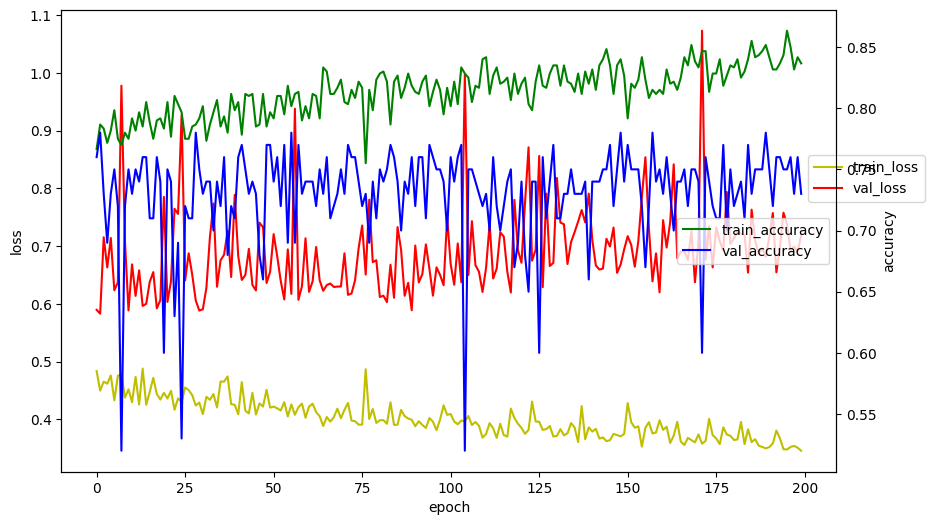

In [52]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [53]:
# 모델 평가
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.6262 - accuracy: 0.7941


[0.6261605024337769, 0.7941176295280457]

In [54]:
# 혼동행렬, 교차표 (원핫인코딩을 다시 복구)
# y_test 실제값
y_hat = model.predict(X_test).argmax(axis=1)

3/3 [==============================] - 0s 5ms/step


In [55]:
y_hat

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [56]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,36,5
1.0,9,18


In [57]:
confusion_matrix(y_test, y_hat)

array([[36,  5],
       [ 9, 18]], dtype=int64)

## 6. 모델 사용하기

In [58]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [59]:
X_test[0].reshape(-1, 8) # 2차원 배열만 학습 가능

array([[  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
         26.   ]])

In [60]:
pred = model.predict(X_test[0].reshape(-1, 8)) # 2차원 배열만 학습 가능
pred.argmax(axis=1)

1/1 [==============================] - 0s 28ms/step


array([0], dtype=int64)

In [64]:
pred

array([[0.5550869, 0.4449131]], dtype=float32)

In [63]:
# 몇 %의 확률로 0이라고 예측했니?
pred[0, pred.argmax()] * 100

55.50869107246399